In [1]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 기본 라이브러리
import numpy as np
import pandas as pd

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# 시각화 스타일
sns.set(style="whitegrid")


In [10]:
!apt-get update -qq
!apt-get install -y fonts-nanum



W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.


In [11]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 경로
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

# 폰트 등록
fm.fontManager.addfont(font_path)
font = fm.FontProperties(fname=font_path)

# matplotlib 기본 폰트로 설정 (이게 중요)
plt.rcParams['font.family'] = font.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지


In [3]:
# CSV 파일 경로
path = "/content/drive/MyDrive/Colab Notebooks/heart_failure.csv"

# 데이터 로드
df = pd.read_csv(path)

# 데이터 확인
df.head()


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
# 데이터 구조 확인
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [5]:
# 사망 / 생존 비율 확인
death_counts = df['DEATH_EVENT'].value_counts()

print(death_counts)
print(death_counts / len(df))


DEATH_EVENT
0    203
1     96
Name: count, dtype: int64
DEATH_EVENT
0    0.67893
1    0.32107
Name: count, dtype: float64


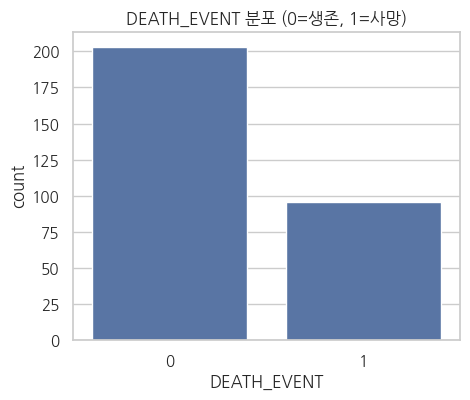

In [12]:
# 시각화
plt.figure(figsize=(5,4))
sns.countplot(x='DEATH_EVENT', data=df)
plt.title("DEATH_EVENT 분포 (0=생존, 1=사망)")
plt.show()


In [14]:
# 타깃
target = 'DEATH_EVENT'

# 이진 변수 (0/1)
binary_cols = [
    'anaemia',
    'diabetes',
    'high_blood_pressure',
    'sex',
    'smoking'
]

# 연속형 변수
continuous_cols = [
    'age',
    'creatinine_phosphokinase',
    'ejection_fraction',
    'platelets',
    'serum_creatinine',
    'serum_sodium',
    'time'
]


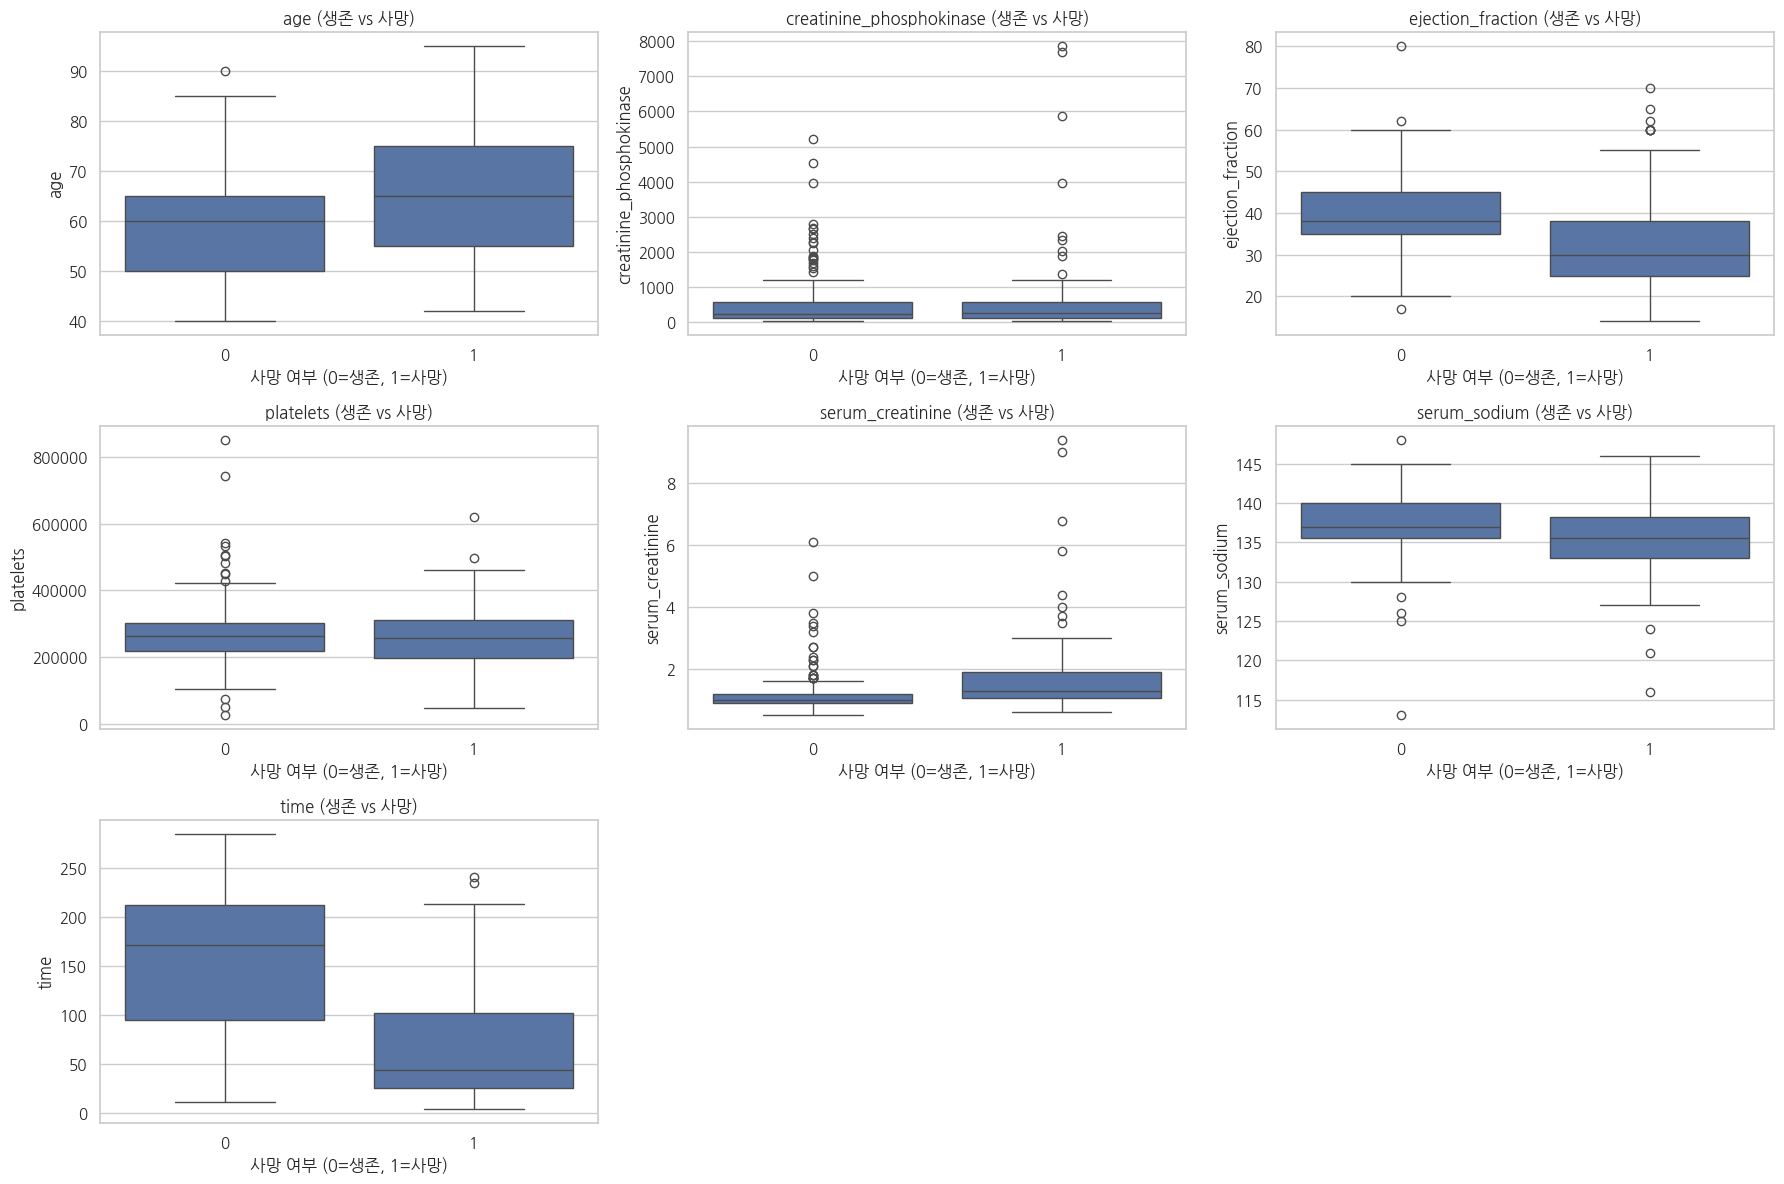

In [15]:
plt.figure(figsize=(18, 12))

for i, col in enumerate(continuous_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=target, y=col, data=df)
    plt.title(f"{col} (생존 vs 사망)")
    plt.xlabel("사망 여부 (0=생존, 1=사망)")
    plt.ylabel(col)

plt.tight_layout()
plt.show()


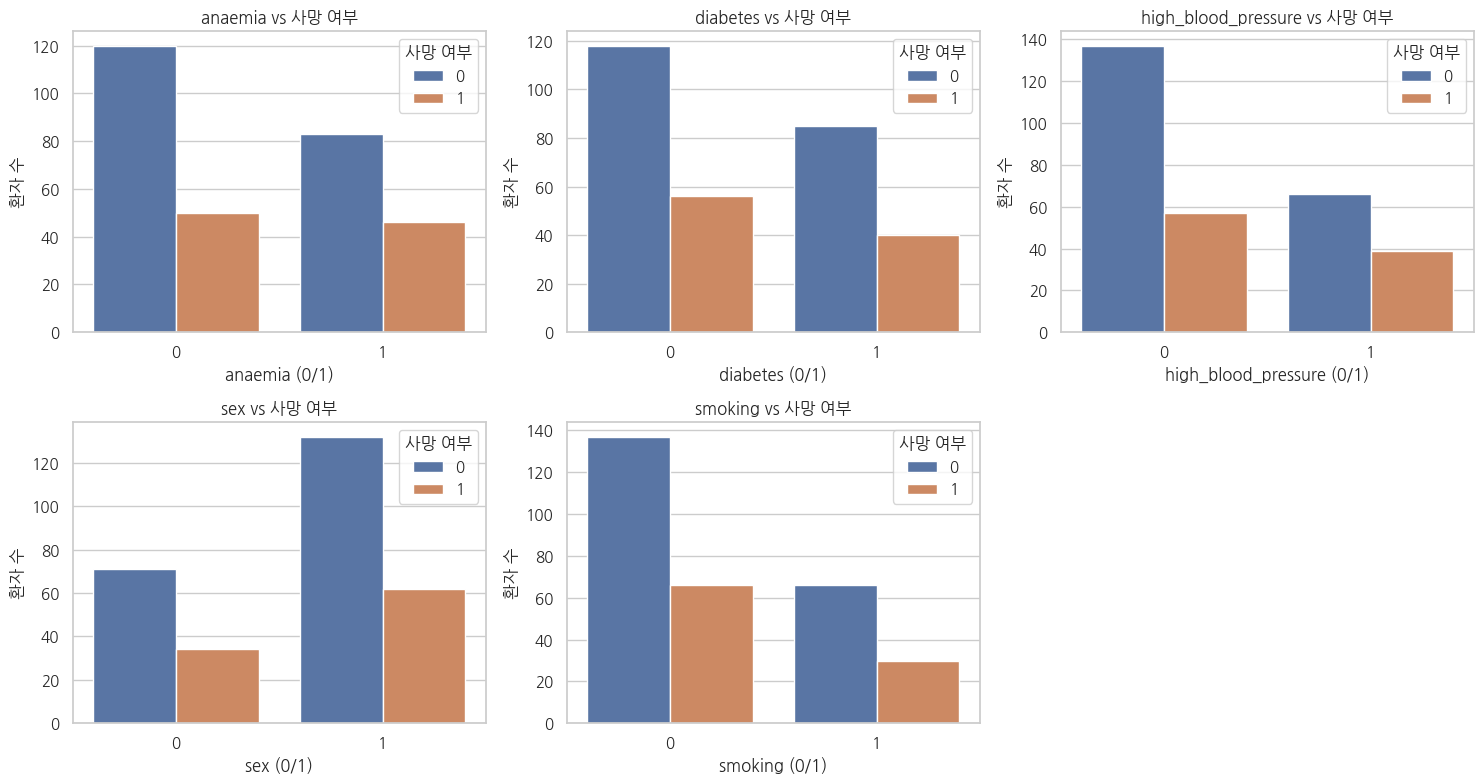

In [16]:
plt.figure(figsize=(15, 8))

for i, col in enumerate(binary_cols, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=col, hue=target, data=df)
    plt.title(f"{col} vs 사망 여부")
    plt.xlabel(f"{col} (0/1)")
    plt.ylabel("환자 수")
    plt.legend(title="사망 여부")

plt.tight_layout()
plt.show()


In [17]:
# 이진 변수별 사망 비율 계산
death_rate = {}

for col in binary_cols:
    death_rate[col] = df.groupby(col)[target].mean()

death_rate_df = pd.DataFrame(death_rate)
death_rate_df


,anaemia,diabetes,high_blood_pressure,sex,smoking
0,0.294118,0.321839,0.293814,0.323810,0.325123
1,0.356589,0.320000,0.371429,0.319588,0.312500


In [26]:
# ===============================
# 목표:
#   - 머신러닝 모델이 학습할 입력 데이터(X)
#   - 우리가 예측하고 싶은 정답(y)을 분리
# ===============================

# y : 예측 대상 (사망 여부)
# 0 = 생존, 1 = 사망
y = df['DEATH_EVENT']

# X : 입력 변수들 (사망 여부 컬럼 제거)
X = df.drop(columns=['DEATH_EVENT'])

# 분리 잘 됐는지 형태 확인
print("X shape:", X.shape)  # (행 개수, 변수 개수)
print("y shape:", y.shape)  # (행 개수,)


X shape: (299, 12)
y shape: (299,)


In [27]:
# ===============================
# 목표:
#   - 모델이 학습하는 데이터(train)
#   - 모델 성능을 평가하는 데이터(test)
# ===============================

from sklearn.model_selection import train_test_split

# stratify=y :
#   - 사망(1) / 생존(0) 비율이
#     train과 test에 비슷하게 유지되도록 함 (중요!)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 전체 데이터의 20%를 test로 사용
    random_state=42,     # 결과 재현을 위해 고정
    stratify=y           # 클래스 비율 유지
)

# 분리 결과 확인
print("Train X:", X_train.shape, "Train y:", y_train.shape)
print("Test  X:", X_test.shape,  "Test  y:", y_test.shape)


Train X: (239, 12) Train y: (239,)
Test  X: (60, 12) Test  y: (60,)


In [28]:
# ===============================
# 목표:
#   - 로지스틱 회귀는 변수 크기에 민감
#   - 평균 0, 표준편차 1로 맞춰줌 (표준화)
# ===============================

from sklearn.preprocessing import StandardScaler

# 스케일러 객체 생성
scaler = StandardScaler()

# ⚠️ 반드시 train 데이터로만 fit!
# (test 정보를 미리 보면 안 됨 = 데이터 누수 방지)
X_train_scaled = scaler.fit_transform(X_train)

# train에서 학습한 기준으로 test 변환
X_test_scaled = scaler.transform(X_test)


In [29]:
# ===============================
# 목표:
#   - 해석 가능한 기준 모델 생성
#   - "왜 사망으로 예측했는지" 설명 가능
# ===============================

from sklearn.linear_model import LogisticRegression

# 로지스틱 회귀 모델 생성
log_model = LogisticRegression(
    max_iter=1000,   # 반복 횟수 증가 (수렴 안정)
    random_state=42
)

# 학습 (스케일링된 데이터 사용)
log_model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [30]:
# ===============================
# 목표:
#   - 모델이 사망(1)을 얼마나 잘 맞추는지 평가
#   - Accuracy 말고 Recall, F1 중요!
# ===============================

from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score,
    confusion_matrix, classification_report
)

# 테스트 데이터로 예측
y_pred_log = log_model.predict(X_test_scaled)

# 주요 평가 지표 출력
print("=== Logistic Regression 성능 ===")
print("Accuracy :", accuracy_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log))
print("Recall   :", recall_score(y_test, y_pred_log))
print("F1-score :", f1_score(y_test, y_pred_log))

print("\n[Confusion Matrix]")
print(confusion_matrix(y_test, y_pred_log))

print("\n[Classification Report]")
print(classification_report(y_test, y_pred_log))


=== Logistic Regression 성능 ===
Accuracy : 0.8166666666666667
Precision: 0.7857142857142857
Recall   : 0.5789473684210527
F1-score : 0.6666666666666666

[Confusion Matrix]
[[38  3]
 [ 8 11]]

[Classification Report]
              precision    recall  f1-score   support

           0       0.83      0.93      0.87        41
           1       0.79      0.58      0.67        19

    accuracy                           0.82        60
   macro avg       0.81      0.75      0.77        60
weighted avg       0.81      0.82      0.81        60



In [31]:
# ===============================
# 목표:
#   - 각 변수가 사망 예측에 미치는 영향 확인
# ===============================

# 계수 정리
coef_df = pd.DataFrame({
    '변수': X.columns,
    '계수': log_model.coef_[0]
})

# 절댓값 기준으로 영향 큰 변수부터 정렬
coef_df['절댓값'] = coef_df['계수'].abs()
coef_df = coef_df.sort_values(by='절댓값', ascending=False)

# 상위 10개 변수 확인
coef_df.head(10)


,변수,계수,절댓값
11,time,-1.577011,1.577011
4,ejection_fraction,-0.909601,0.909601
7,serum_creatinine,0.787676,0.787676
0,age,0.416343,0.416343
2,creatinine_phosphokinase,0.275913,0.275913
3,diabetes,0.242201,0.242201
9,sex,-0.200936,0.200936
6,platelets,-0.139808,0.139808
8,serum_sodium,-0.137449,0.137449
10,smoking,0.111317,0.111317


In [32]:
# ===============================
# 목표:
#   - 비선형 관계까지 잘 잡는 성능 중심 모델
# ===============================

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,        # 트리 개수
    random_state=42,
    class_weight='balanced' # 사망(1) 클래스 보정
)

# 트리 모델 → 스케일링 X
rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)

In [33]:
# 테스트 데이터로 예측
y_pred_rf = rf_model.predict(X_test)

print("=== RandomForest 성능 ===")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall   :", recall_score(y_test, y_pred_rf))
print("F1-score :", f1_score(y_test, y_pred_rf))

print("\n[Confusion Matrix]")
print(confusion_matrix(y_test, y_pred_rf))

print("\n[Classification Report]")
print(classification_report(y_test, y_pred_rf))


=== RandomForest 성능 ===
Accuracy : 0.85
Precision: 0.8571428571428571
Recall   : 0.631578947368421
F1-score : 0.7272727272727273

[Confusion Matrix]
[[39  2]
 [ 7 12]]

[Classification Report]
              precision    recall  f1-score   support

           0       0.85      0.95      0.90        41
           1       0.86      0.63      0.73        19

    accuracy                           0.85        60
   macro avg       0.85      0.79      0.81        60
weighted avg       0.85      0.85      0.84        60



In [34]:
# ===============================
# 목표:
#   - RandomForest가 중요하다고 판단한 변수 확인
# ===============================

importance_df = pd.DataFrame({
    '변수': X.columns,
    '중요도': rf_model.feature_importances_
})

# 중요도 기준 정렬
importance_df = importance_df.sort_values(by='중요도', ascending=False)

# 상위 5개 변수
importance_df.head(5)


,변수,중요도
11,time,0.368621
7,serum_creatinine,0.157395
4,ejection_fraction,0.129925
2,creatinine_phosphokinase,0.074724
6,platelets,0.072157


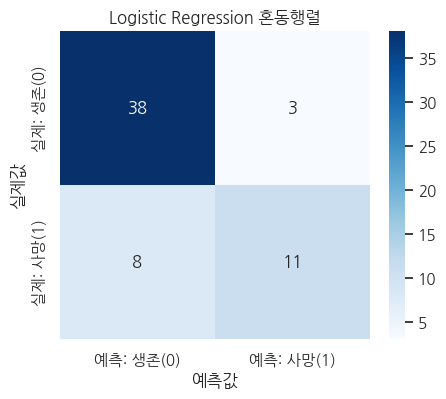

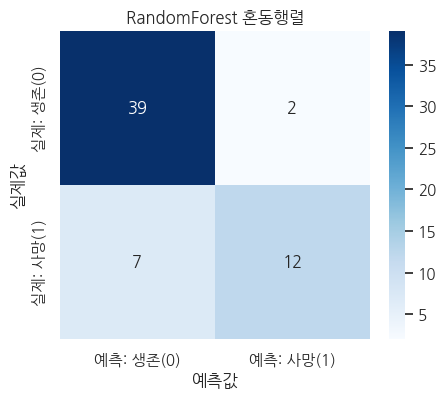

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ===============================
# 목표:
#   - 혼동행렬(Confusion Matrix)을 그림으로 보여주기
#   - 사망(1)을 얼마나 놓치는지(FN) 한눈에 확인
# ===============================

def plot_confusion_matrix(y_true, y_pred, title):
    """
    y_true: 실제 정답
    y_pred: 모델 예측값
    title : 그래프 제목
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm,
        annot=True, fmt='d',
        cmap='Blues',
        xticklabels=['예측: 생존(0)', '예측: 사망(1)'],
        yticklabels=['실제: 생존(0)', '실제: 사망(1)']
    )
    plt.title(title)
    plt.xlabel("예측값")
    plt.ylabel("실제값")
    plt.show()

# 로지스틱 회귀 혼동행렬
plot_confusion_matrix(y_test, y_pred_log, "Logistic Regression 혼동행렬")

# 랜덤포레스트 혼동행렬
plot_confusion_matrix(y_test, y_pred_rf, "RandomForest 혼동행렬")


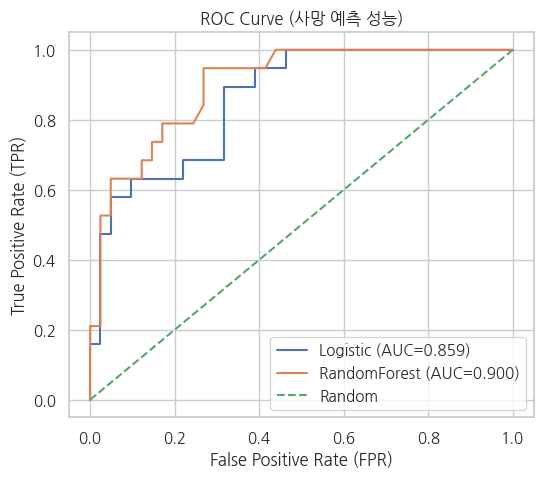

In [36]:
from sklearn.metrics import roc_curve, auc

# ===============================
# 목표:
#   - 임계값(threshold)을 바꿔가며 성능을 보는 ROC Curve
#   - AUC가 1에 가까울수록 분류 성능이 좋음
# ===============================

# 로지스틱 회귀: 사망(1)일 확률 예측
y_proba_log = log_model.predict_proba(X_test_scaled)[:, 1]

# 랜덤포레스트: 사망(1)일 확률 예측
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# ROC 좌표 계산
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

# AUC 계산
auc_log = auc(fpr_log, tpr_log)
auc_rf = auc(fpr_rf, tpr_rf)

# 시각화
plt.figure(figsize=(6,5))
plt.plot(fpr_log, tpr_log, label=f"Logistic (AUC={auc_log:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC={auc_rf:.3f})")

# 랜덤 추측 기준선
plt.plot([0,1], [0,1], linestyle="--", label="Random")

plt.title("ROC Curve (사망 예측 성능)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()
plt.show()


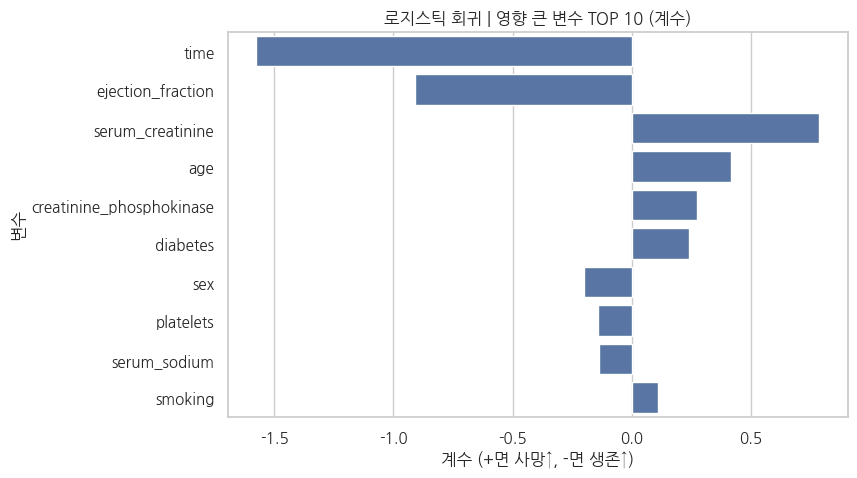

In [37]:
# ===============================
# 목표:
#   - 로지스틱 회귀는 "왜 사망으로 판단했는지" 설명 가능
#   - 계수(+)면 사망 확률↑, 계수(-)면 생존 확률↑
# ===============================

# coef_df는 앞에서 만든 것 사용
# (혹시 없으면 다시 만들기)
coef_df = pd.DataFrame({
    '변수': X.columns,
    '계수': log_model.coef_[0]
})
coef_df['절댓값'] = coef_df['계수'].abs()
coef_df = coef_df.sort_values(by='절댓값', ascending=False)

top10_coef = coef_df.head(10)

plt.figure(figsize=(8,5))
sns.barplot(x='계수', y='변수', data=top10_coef)
plt.title("로지스틱 회귀 | 영향 큰 변수 TOP 10 (계수)")
plt.xlabel("계수 (+면 사망↑, -면 생존↑)")
plt.ylabel("변수")
plt.show()


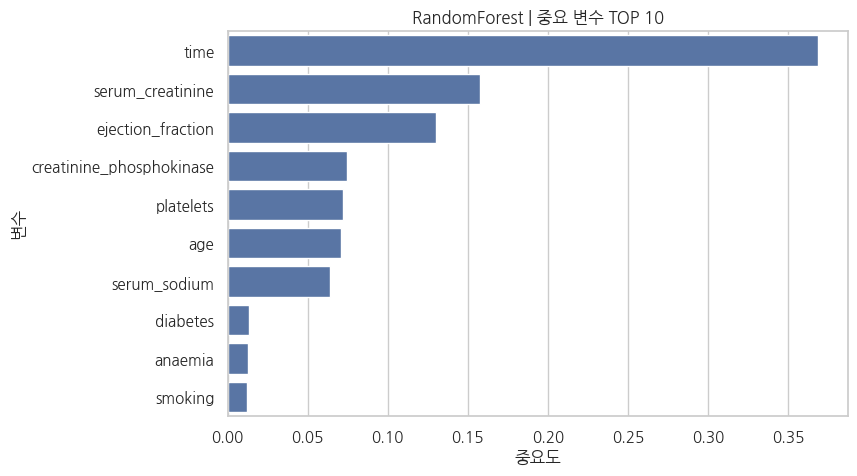

In [38]:
# ===============================
# 목표:
#   - 랜덤포레스트가 중요하게 본 변수 확인
#   - 단, coef처럼 방향(↑/↓)은 알려주지 않음
# ===============================

importance_df = pd.DataFrame({
    '변수': X.columns,
    '중요도': rf_model.feature_importances_
}).sort_values(by='중요도', ascending=False)

top10_imp = importance_df.head(10)

plt.figure(figsize=(8,5))
sns.barplot(x='중요도', y='변수', data=top10_imp)
plt.title("RandomForest | 중요 변수 TOP 10")
plt.xlabel("중요도")
plt.ylabel("변수")
plt.show()


In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ===============================
# 목표:
#   - 두 모델 성능을 표로 깔끔하게 비교
# ===============================

result_df = pd.DataFrame({
    "모델": ["Logistic Regression", "RandomForest"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_rf)
    ],
    "Precision": [
        precision_score(y_test, y_pred_log),
        precision_score(y_test, y_pred_rf)
    ],
    "Recall": [
        recall_score(y_test, y_pred_log),
        recall_score(y_test, y_pred_rf)
    ],
    "F1": [
        f1_score(y_test, y_pred_log),
        f1_score(y_test, y_pred_rf)
    ]
})

result_df


,모델,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.816667,0.785714,0.578947,0.666667
1,RandomForest,0.850000,0.857143,0.631579,0.727273
